In [156]:
import spacy
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib notebook

In [119]:
nlp = spacy.load('en')

In [128]:
subsample = 200
path_inputs = os.path.join('data', 'cases')
path_labels = os.path.join('data')
df = pd.DataFrame(columns=['Sentences', 'Words', 'Letters']).astype(np.int64)
filenames = [filename for filename in os.listdir(path_inputs)]

In [129]:
# Here we split the documents into sentences and tokens
# Count the number of sentences, words and letters for each doument
for filename in filenames[:subsample]:
    with open(os.path.join(path_inputs, filename)) as f:
        doc = nlp(f.read())
        # Count
        sentences = len(list(doc.sents))
        words = 0
        letters = 0
        for token in doc:
            if not token.is_space and not token.is_punct:
                words += 1
                letters += len(token)
        # Add to dataframe
        new_entry = {'Sentences': sentences, 'Words': words, 'Letters': letters}
        df = df.append(new_entry, ignore_index=True)

<IPython.core.display.Javascript object>


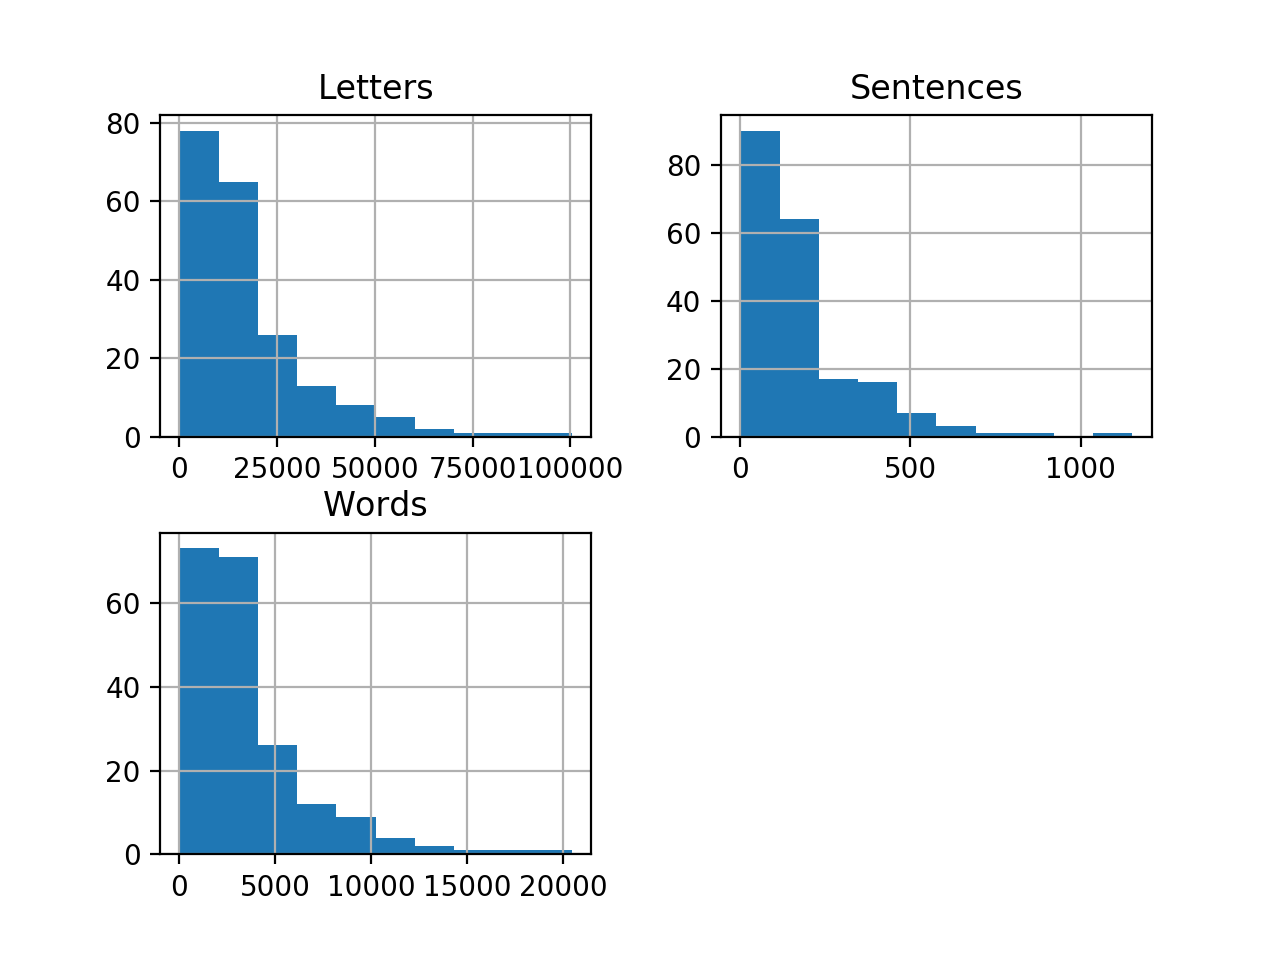

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13f077630>,
      dtype=object)

In [130]:
# Report histogram for the computed statistics
df[['Words', 'Sentences', 'Letters']].hist()

In [131]:
# Count nouns, verbs, adjectives in each document
# nouns,verbs,adjectives, index rows by year +=
# firts 4 letter of filenames
years = list(set(([int(filename[:4]) for filename in filenames])))
dfPOS = pd.DataFrame(np.zeros((len(years), 3)), index=years, columns=['Nouns', 'Verbs', 'Adjectives']).astype(np.int64)
dfPOS.sort_index(inplace=True)
# subsample = 1000

# Here we split the documents into sentences and tokens
# Count the number of sentences, words and letters for each doument
for filename in filenames[:subsample]:
    with open(os.path.join(path_inputs, filename)) as f:
        doc = nlp(f.read())
        # Count
        nouns = 0
        adjectives = 0
        verbs = 0
        year = int(filename[:4])
        for token in doc:
            if token.pos_ == 'VERB':
                verbs += 1
            elif token.pos_ == 'NOUN':
                nouns += 1
            elif token.pos_ == 'ADJ':
                adjectives += 1
        # Add to dataframe
        new_entry = dfPOS.loc[year]
        new_entry['Nouns'] += nouns
        new_entry['Adjectives'] += adjectives
        new_entry['Verbs'] += verbs
        dfPOS.loc[year] = new_entry

<IPython.core.display.Javascript object>


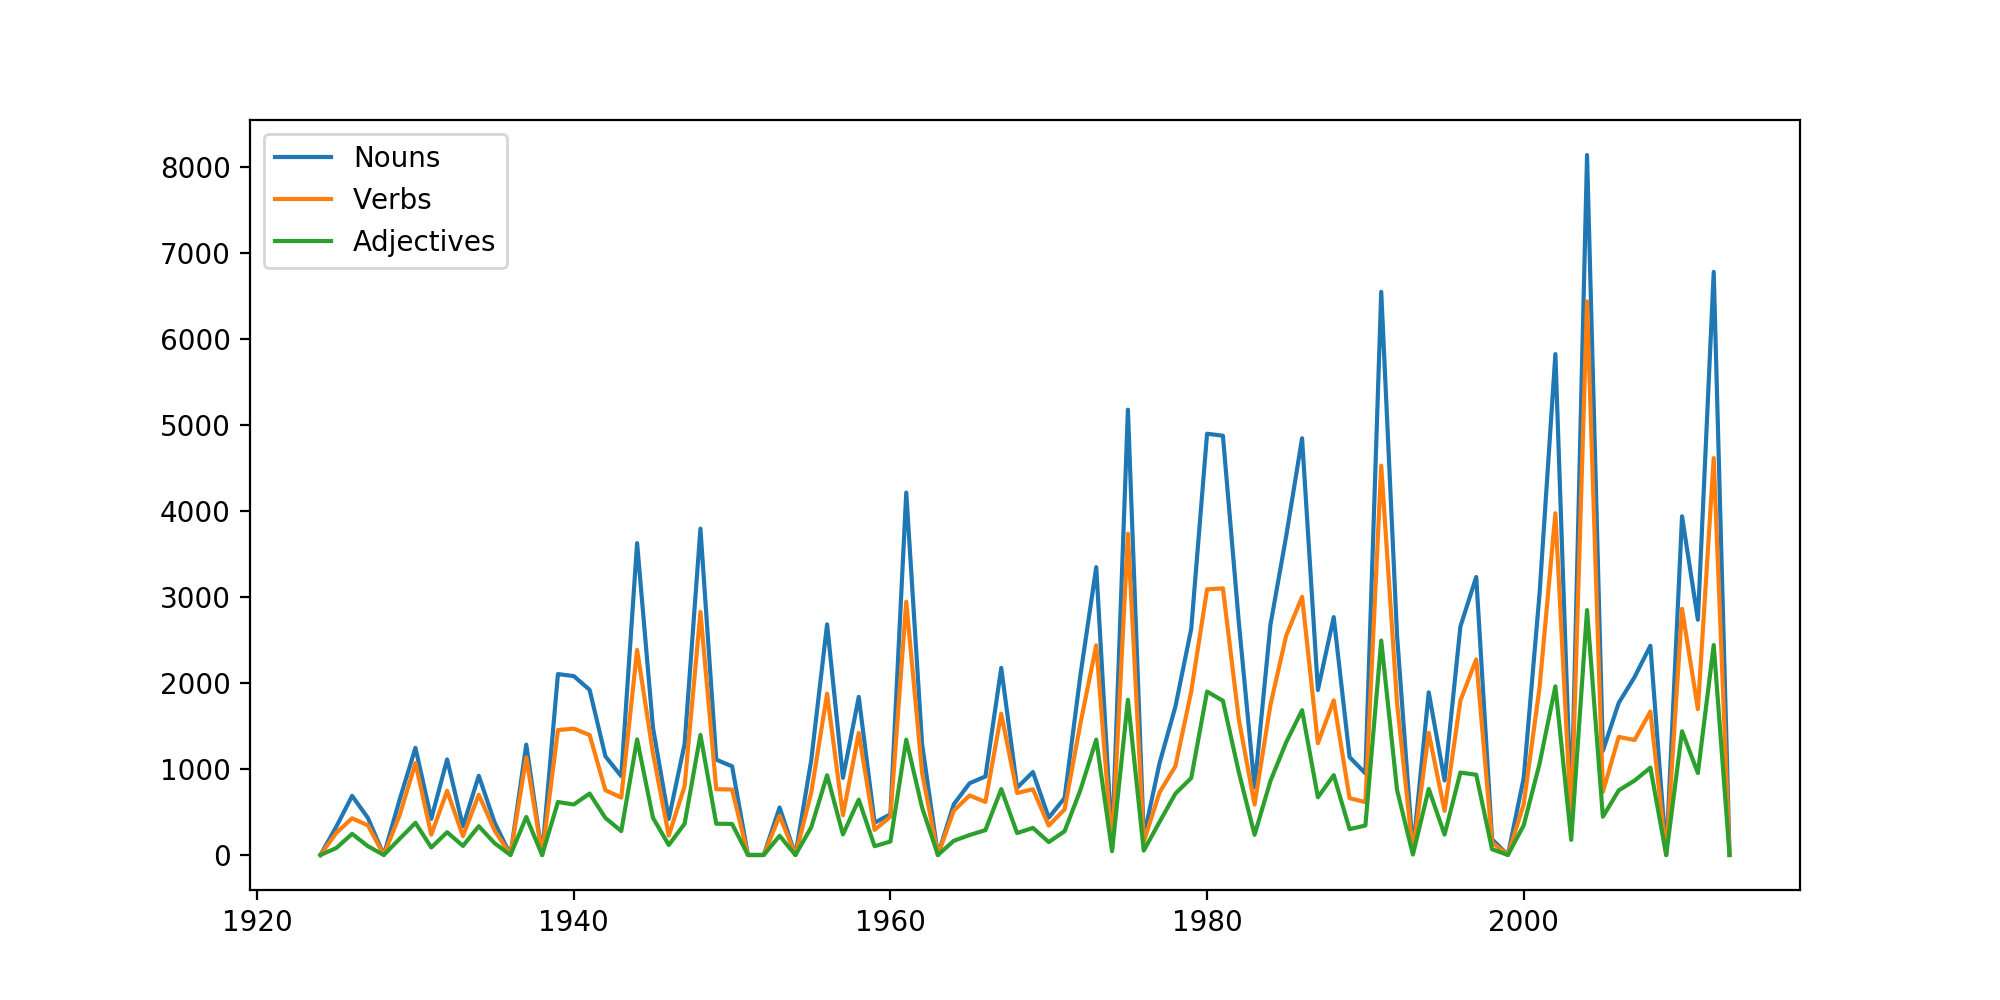

In [132]:
# Visualize POS frequency by year
dfPOS[:].plot(figsize=(10,5))

# Normalizing corpus

Normalizing the corpus, remove punctuation and other information, discuss what normalizations you make
make a feature set of all trigrams that end in a noun


In [133]:
# remove punctionation, whitespace, stop words as they dont change the meaning, use lemmatization
# create trigrams on remaining tokens

# count occurences of each normalized trigram that ends in a noun
trigram_count = {}

# subsample = 1000
LEMMA = 0
POS = 1 #index of part-of-speech

for filename in filenames[:subsample]:
    with open(os.path.join(path_inputs, filename)) as f:
        doc = nlp(f.read())
        toks = [(token.lemma_, token.pos_) for token in doc if not token.is_space if not token.is_punct if not token.is_stop]
        for i in range(len(toks)):
            if i < 2:
                continue # start from 3rd token
            pos = toks[i][POS]
            if (pos == 'NOUN'):
                trigram = (toks[i][LEMMA], toks[i - 1][LEMMA], toks[i - 2][LEMMA])
                if trigram in trigram_count:
                    trigram_count[trigram] += 1
                else:
                    trigram_count[trigram] = 1

In [134]:
TOP = 1000
# sort descending by the value(count) and select the first TOP
top_trigrams, _ = map(list, zip(*(sorted(list(trigram_count.items()), key=lambda x: -x[1])[:TOP])))

In [174]:
# Make a dataframe of the 1000 trigram features and add a new entry per document

# subsample = 1000
cases = sorted(list(([filename[5:-4] for filename in filenames]))[:subsample])
dfTRI = pd.DataFrame(np.zeros((len(cases), len(top_trigrams))), index=cases, columns=top_trigrams).astype(np.int64)

for filename in filenames[:subsample]:
    with open(os.path.join(path_inputs, filename)) as f:
        doc = nlp(f.read())
        toks = [(token.lemma_, token.pos_) for token in doc if not token.is_space if not token.is_punct if not token.is_stop]
        for i in range(len(toks)):
            if i < 2:
                continue # start from 3rd token
            pos = toks[i][POS]
            if (pos == 'NOUN'):
                trigram = (toks[i][LEMMA], toks[i - 1][LEMMA], toks[i - 2][LEMMA])
                if trigram in top_trigrams:
                    dfTRI.at[filename[5:-4], trigram] += 1

In [175]:
# normalize unit variance per feature
dfTRI_normalized = dfTRI / dfTRI.std()

In [178]:
# load reverse and link it with this to a new dataframe
# Add new column
# dfTRI_normalized['case_reversed'] = 0

df_reverse = pd.read_csv(os.path.join(path_labels, 'case_reversed.csv')).set_index('caseid').loc[cases]

# add the entries to the other dataframa
# for index, row in df_reverse.iterrows():
#     if row.caseid in dfTRI_normalized.index:
#         dfTRI_normalized.case_reversed = row.case_reversed

In [179]:
count = 0
total = 0
for index, row in df_reverse.iterrows():
    total += 1
    if row.case_reversed:
        count += 1
        
print("TOTAL:",total)
print("CLASS 0:",total-count)
print("CLASS 1:",count)

TOTAL: 200
CLASS 0: 67
CLASS 1: 133


In [201]:
X_train, X_test, y_train, y_test = train_test_split(dfTRI_normalized, df_reverse, test_size=0.15)
# chekc if they have they same elements otherwise you need oto sort the indices
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train.case_reversed)
y_pred = clf.predict(X_test)
print(y_pred)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

# clf.predict_proba(X[:2, :]) 
# clf.score(X, y)
# f1_score(y_true, y_pred, average='macro') 

[1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0]
0.6829268292682927
0.5666666666666667


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
0.7058823529411765
0.6
0.5138888888888888


<IPython.core.display.Javascript object>


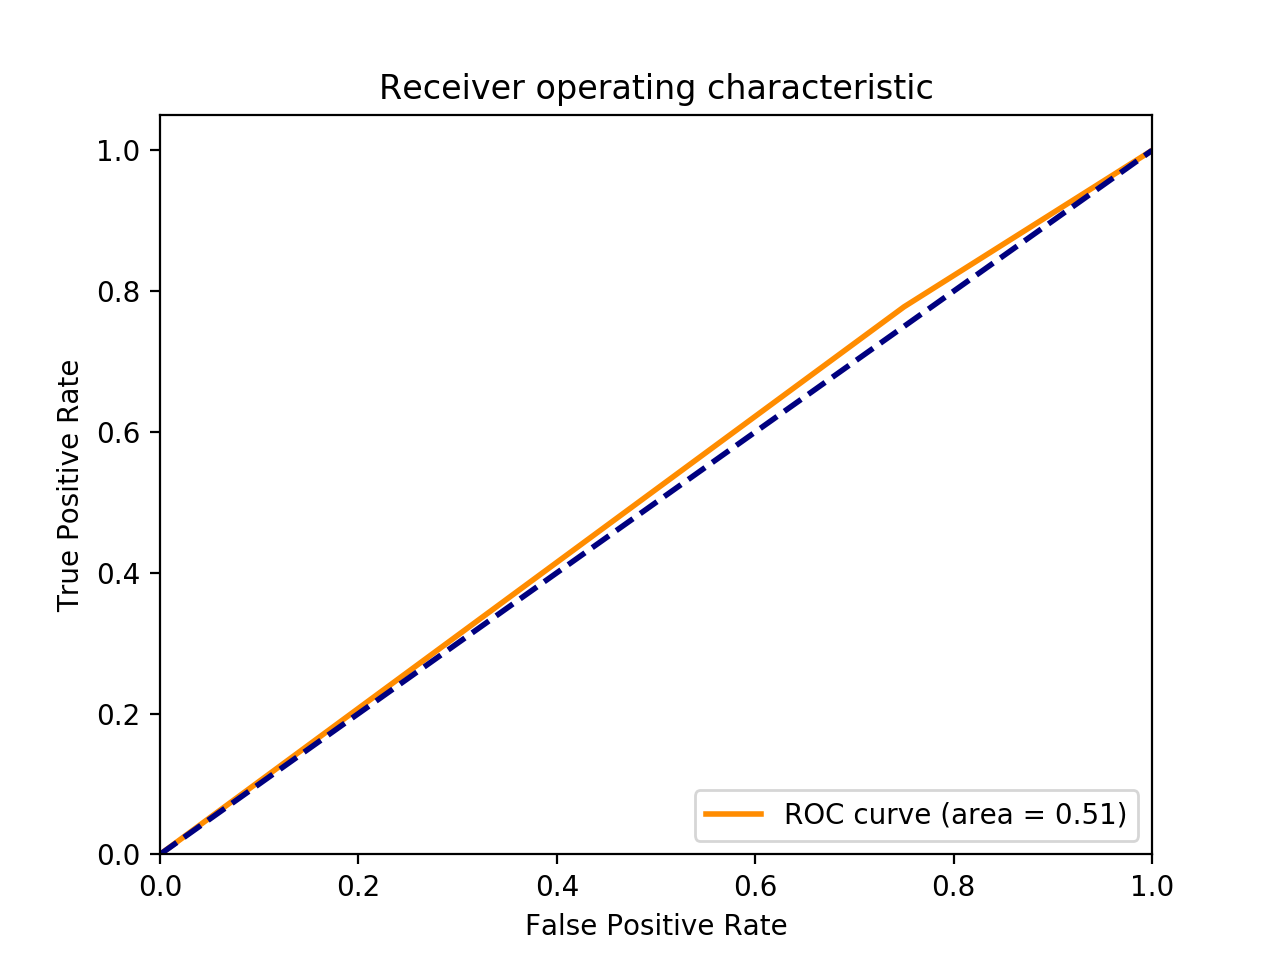

In [218]:
# Grid searchCV
import pprint
from sklearn.model_selection import GridSearchCV
parameters = {'penalty':('l1', 'l2'), 'C':[0.1, 2]}
logistic = LogisticRegression(solver='liblinear')
clf = GridSearchCV(logistic, parameters, cv=5)
clf.fit(X_train, y_train.case_reversed)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(clf.get_params()['estimator'])
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Make a new dataframe where each sentence (of each case) is treated as a separate document. Compute vader compound sentiment scores for each sentence and report the top 10 highest- and lowest-sentiment sentences.


In [302]:
dfs = {} # multiple dataframes
df_sent = pd.DataFrame(columns=['txt']).astype(str)
for filename in filenames[:subsample]:
    with open(os.path.join(path_inputs, filename)) as f:
        doc = nlp(f.read())
        for sent in doc.sents:
            df_sent = df_sent.append({'txt':sent.text}, ignore_index=True)
dfs['sent'] = df_sent

In [303]:
# for all docs
#     for all sents
#         compute score
#         keep top 10 in a heap and bottom 10
# Here we split the documents into sentences and tokens
# Count the number of sentences, words and letters for each doument

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import bisect 

sentiment_analyzer = SentimentIntensityAnalyzer()
best = []
worst = []
TOPELEMS = 10

for _, row in dfs['sent'].iterrows():
    sent = row.txt
    score = sentiment_analyzer.polarity_scores(sent)['compound']
    if len(best) < TOPELEMS or score > best[-1][0]:
        if len(best) >= TOPELEMS:
            best.pop()
        pos = 0
        for sc, _ in best:
            if sc > score:
                break
            pos += 1
        best.insert(pos, (score, sent))

    if len(worst) < TOPELEMS or score < worst[-1][0]:
        if len(worst) >= TOPELEMS:
            worst.pop()
        pos = len(worst)
        for i in range(len(worst)):
            sc  =  worst[len(worst) - 1- i][0]
            if sc < score:
                break
            pos -= 1
        worst.insert(pos, (score, sent))
                
print(best)
print(worst)


[(-0.5719, 'The railway having failed to pay the amount found due by the Commission, the present suit resulted.\n'), (0.0, ' STONE , Circuit Judge.\n'), (0.0, 'This is an action to recover reparation for a freight overcharge.\n'), (0.0, 'From the judgment according reparation this appeal is brought.\n'), (0.0258, 'The matter was first presented to the Interstate Commerce Commission, which found there had been an overcharge and declared reparation.\n'), (0.3089, 'The facts here are not in dispute and are as follows: These shipments were of carloads of grain originating on various points in Minnesota, North and South Dakota, upon the line of appellant.\n'), (0.5423, 'All of them were consigned to Minneapolis and there later sent (by reconsignment without breakage of bulk in the same cars) to Superior, Wis.'), (0.5423, 'The tariffs covering rates from the points of origin to Superior did not indicate that such rates were upon any particular route.\n'), (0.8442, 'Appellant had in force rat

In [304]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
corpus = list(dfs['sent']['txt'])
corpus_tfidf = vectorizer.fit_transform(corpus)
similarity_matrix = cosine_similarity(corpus_tfidf)

# Look for similar and diffent sentences according to the similarity matrix
NUMBER = 5
similar = []
similar_threshold = 0.50
dissimilar = []
dissimilar_threshold = 0.05


found = 0
for i in range(len(corpus)):
    for j in range(i + 1, len(corpus)):
        if similarity_matrix[i][j] > similar_threshold:
            print('SIMILAR:')
            print(corpus[i])
            print(corpus[j])
            print('Score: ', similarity_matrix[i][j])
            print()
            found += 1
            break # use a different sentence
    if found >= NUMBER:
        break
         
            
found = 0         
for i in range(len(corpus)):
    for j in range(i + 1, len(corpus)):
        if similarity_matrix[i][j] < dissimilar_threshold:
            print('DISSIMILAR:')
            print(corpus[i])
            print(corpus[j])
            print('Score: ', similarity_matrix[i][j])
            print()
            found += 1
            break # use a different sentence
    if found >= NUMBER:
        break
            

SIMILAR:
 STONE , Circuit Judge.

In Stone v. Stone , 632 F.2d 740 (9th Cir.1980), cert.
Score:  0.556108210380736

SIMILAR:
From the judgment according reparation this appeal is brought.

Reparation is denied."

Score:  0.5107902967890006

SIMILAR:
Appellant had in force rate tariffs prescribing certain rates from the points of origin of these shipments to Superior, rates to Minneapolis, and "proportional" rates from Minneapolis to Superior.

In the instance of each shipment there was a shorter mileage route from the point of origin to Superior, and in each instance the rate to Superior was less than the combination of the rate to Minneapolis plus the proportional rate from Minneapolis to Superior.

Score:  0.5296911411691242

SIMILAR:
In the instance of each shipment there was a shorter mileage route from the point of origin to Superior, and in each instance the rate to Superior was less than the combination of the rate to Minneapolis plus the proportional rate from Minneapolis to Su

Use k-means clustering to assign the sentences into 20 clusters. List 5 example sentences from each cluster. 


In [311]:
# Use tfidf scores for clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=0).fit(corpus_tfidf)



Cluster 1


TypeError: only integer scalar arrays can be converted to a scalar index

In [342]:
npcorp = np.array(corpus, dtype=str)
for cluster_no in range(1,20,1):
    print(cluster_no)
    print('Cluster {}'.format(cluster_no))
    this_cluster = npcorp[kmeans.labels_ == cluster_no]
    if this_cluster.shape[0] > 5:
        this_cluster = this_cluster.sample(5)
    for sent in this_cluster:
        print(sent)

1
Cluster 1


AttributeError: 'numpy.ndarray' object has no attribute 'sample'